In [33]:
# from sentence_transformers import SentenceTransformer
#
# sentenceModel = SentenceTransformer('all-mpnet-base-v2')
#
# embeddings = sentenceModel.encode(data['post'])

In [34]:
import string
import numpy as np
import random
import nltk
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import pandas as pd

custom_words_to_filter = ['Reuters', 'Reuters.com', 'CNET']

docs_StarWars = ["Count Dooku Voice Actor Corey Burton Tried Something New on Star Wars: Tales of the Jedi", "'Andor' Episode 8 Explained: 'Rogue One' Cameos and a 'Star Wars' Hell Prison - CNET", "Andor Gave Us the Gayest Screen Fade in Star Wars History", "Ahsoka Tano Herself, Ashley Eckstein, Breaks Down Star Wars: Tales of the Jedi", "Star Wars: The Deckbuilding Game could rule the galaxy of 2-player card games", "There's a new Star Wars project from Damon Lindelof in the works", "Star Wars Fatigue Shouldn't Stop You From Watching 'Andor' - CNET", "'Andor' is the best 'Star Wars' show since 'The Mandalorian' — but the least popular", "Star Wars characters take over Mexico City - Reuters"]

docs_China = ["Alarmed by suicide attack, China and Pakistan join hands in probe - Reuters", "Death of boy in lockdown fuels backlash against China's zero-Covid policy", "UPDATE 2-Hong Kong stocks tumble as Xi appointments fan economic fears; yuan weakens", "China supports central SOEs to issue tech innovation bonds - Reuters"]

docs_WorldCup = ["World Cup: FIFA head comments on beer ban - CP24", "T20 World Cup: Bangladesh bowlers impress to secure victory over Netherlands", "Canada's goalkeeper Crepeau to miss World Cup with broken leg - Reuters", "World Cup stadium alcohol ban emblematic of contradictions", "T20 World Cup: Pakistan beat Netherlands to avoid elimination"]

docs_Ukraine = ["Ukraine war: Wagner chief Prigozhin defends brutal killing video", "Chance for peace in Ukraine, says France's Macron - Reuters", "Ukraine nuclear agency thickens alleged dirty bomb plot - CTV News", "Ukraine war round-up: Missile blast in Poland and Zambian family's grief", "Ukraine round-up: Refugees urged to stay away and 'dirty bomb' claims", "Russia says Ukraine hands over 50 prisoners of war - Reuters.com"]

docs = [docs_StarWars, docs_China, docs_WorldCup, docs_Ukraine]
docs = list(np.concatenate(docs).flat)
random.shuffle(docs)

lemmatizer = nltk.stem.WordNetLemmatizer()
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stop_words = nltk.corpus.stopwords.words('english')
words_to_filter = np.concatenate((stop_words, custom_words_to_filter))

def clean_text(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = lemmatizer.lemmatize(text)
    text = tokenizer.tokenize(text)
    text = [word for word in text if word not in words_to_filter]
    text = ' '.join(text)
    text = text.lower()

    return text

docs = [clean_text(doc) for doc in docs]
print(docs)

['star wars characters take mexico city', 'world cup fifa head comments beer ban cp24', 'death boy lockdown fuels backlash chinas zerocovid policy', 'ukraine war wagner chief prigozhin defends brutal killing video', 'ukraine nuclear agency thickens alleged dirty bomb plot ctv news', 'andor episode 8 explained rogue one cameos star wars hell prison', 'star wars the deckbuilding game could rule galaxy 2player card games', 'ahsoka tano herself ashley eckstein breaks down star wars tales jedi', 't20 world cup pakistan beat netherlands avoid elimination', 'alarmed suicide attack china pakistan join hands probe', 't20 world cup bangladesh bowlers impress secure victory netherlands', 'world cup stadium alcohol ban emblematic contradictions', 'canadas goalkeeper crepeau miss world cup broken leg', 'chance peace ukraine says frances macron', 'andor gave us gayest screen fade star wars history', 'andor best star wars show since the mandalorian least popular', 'ukraine roundup refugees urged stay

In [35]:
USE_DATASET = True

if USE_DATASET:
    data = pd.read_csv('stance_data.csv')
    data = data.rename(columns={'post': 'titles', 'new_topic': 'subjects', 'label': 'stances'})
    data['stances'] = data['stances'].astype('category')
    # convert from 0=con, 1=pro, 2=neutral to 0=neg, 1=neu, 2=pro
    neu = data['stances'] == 1
    data.loc[data['stances'] == 2, 'stances'] = 1
    data.loc[neu, 'stances'] = 2
else:
    data = pd.DataFrame(docs, columns=['titles'])
    label_options = ['world cup', 'Andor', 'China', 'Ukraine'] # Ukraine subjects reflecting positive outcome of war (pos = could end 'well')
    subjects = ['world cup', 'world cup', 'world cup', 'Ukraine', 'Andor', 'Ukraine', 'Ukraine', 'Andor', 'Ukraine', 'China', 'China', 'China', 'Andor', 'world cup', 'Andor', 'Andor', 'Andor', 'Andor', 'Ukraine', 'world cup', 'Andor', 'Andor', 'China', 'Ukraine']
    stances = ['neu', 'neg', 'pos', 'neg', 'neu', 'pos', 'neg', 'pos', 'neu', 'neg', 'neu', 'neg', 'pos', 'neg', 'neu', 'neu', 'pos', 'neu', 'neg', 'neu', 'pos', 'pos', 'neg', 'neg']
    data['stances'] = stances
    data['subjects'] = subjects

    # Note that the categorical index has to start at 0 (so -1 for negative stance isn't allowed)
    data.loc[ data['stances'] == 'neg', 'stances' ] = 0
    data.loc[ data['stances'] == 'neu', 'stances' ] = 1
    data.loc[ data['stances'] == 'pos', 'stances' ] = 2

    data['titles'] = data['titles'].astype('str')
    data['subjects'] = data['subjects'].astype('str')
    data['stances'] = data['stances'].astype('category')

# TODO train/test split
data_train = data

pd.set_option('display.max_colwidth', None)
display(data)
print(data.dtypes)

,titles,subjects,stances
0,"Regulation of corporations has been subverted by corporations. States that incorporate corporations are not equipped to regulate corporations that are rich enough to influence elections, are rich enough to muster a legal team that can bankrupt the state. Money from corporations and their principals cannot be permitted in the political process if democracy is to survive.",regulation,0
1,"Absolutely it's needs to be defined and regulated in its use, as currently the word 'natural' when used on food products is totally confusing and meaningless. Clearly they are trying to imply the item is 'healthy' or possibly 'organic', but when you see food 'manufacturers' like Frito-Lay or Campbell's with products labelled 'natural', that alone should set off alarms that all is not what it seems. ;-)",healthy,2
2,"""...one must ask how much money they must make to demonstrate that they are among the best managed companies on the planet."" They must make enough money to insure that they can never fail and threaten the stability of the worlds economy again. That much money.",the economy,0
3,"The whole media mess surrounding the royals is a consequence of the promotional fervor with which royal households (aka, public relations experts) developed stage-set performances for the public to devour. Prior to the Victorian era, those elaborate and lethally expensive weddings, coronations, and funerals - and the fairy tales that went along with them - just didn't exist.",the royals,2
4,"Violence is inherent in the sex industry only in the same way that criminality is inherent in business in Russia. All private business in Russia was illegal under communism, so when communism fell, the first and strongest entrants were people from criminal backgrounds who had already been engaging in it illegally. They have not yet lost control; not enough time has passed. Similarly, because prostitution has been illegal in many places, even where it has become legal, there is a tendency for it to initially be dominated by the sometimes violent pimps who prevailed when it was illegal. As time passes, in large areas where it is fully legal, it will become less dominated by the criminal element and less violent (although it will never cease to be unpleasant in other ways).",prostituion,2
...,...,...,...
1716,"Allowing maximum access does not cause maximum use. It distributes use over a broader set of beaches, actually reducing crowding. Further, people don't change rental-car oil because that is the contractual responsibility of the rental company. It is not akin to a commons. The shore is a commons and the public has both the right to enjoy it and he responsibility to protect it.",rental companys,2
1717,The issue is what do I have to pay for the bankers to have the privlege of using my money to make a profit. In older times they went out and made good investments. Now they just want to shake me down for every last farthing. Shame on them. They will be made to change and the sooner the better.,banker,0
1718,"I personally believe that whatever the outcome of the civil war, the one outcome which would lead to a much wider and more destructive war would be a true victory by Assad's forces which would empower Hezbollah and project Iranian power through its erstwhile clients to the shores of the Mediterranean. This is a truly regionally destabilizing possibility which would present many powers in the area with difficult potentially war causing choices. That fear draws ample support from the powers that most fear that outcome and it tends to place those resources in the hands of the most destabilizing forces in the opposition which include the most militant of islamists and those bearing the greatest ressentinent against Shiites and minority groups in Syria. The only way to stanch that flow of resources is to at least supply the most acceptable opposition forces and to marginalize the more dangerous opposition actors. What all this means is that inte

titles        object
subjects      object
stances     category
dtype: object


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 titles (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 subjects (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['titles[0][0]',                 
                                (None, 128),                      'subjects[0][0]']               
                                 'input_mask': (Non                                               
                                e, 128),                                                    

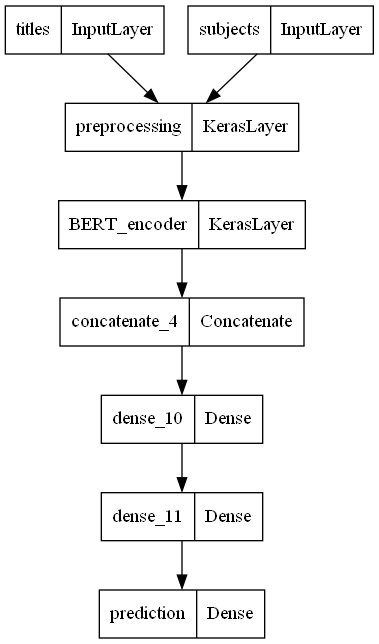

In [36]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4"
hidden_layer_sizes = [300, 100]
alpha_leaky_relu = 0.01
dropout = 0
number_of_output_classes = 3

def build_classifier_model():
    # Handle categorical labels
    # encoded_stance = get_category_encoding_layer(name='categorical', dataset=data_train, dtype='string')

    # BERT embeddings
    preprocessor = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')

    titles = tf.keras.layers.Input(shape=(), dtype=tf.string, name='titles')
    titles_preprocessed = preprocessor(titles)

    subjects = tf.keras.layers.Input(shape=(), dtype=tf.string, name='subjects')
    subjects_preprocessed = preprocessor(subjects)

    # pooled_output gives the embedding per input sequence, alternatively sequence_output would give it per input token
    titles_embedded = encoder(titles_preprocessed)["pooled_output"]
    subjects_embedded = encoder(subjects_preprocessed)["pooled_output"]

    # Concat features
    # titles_embedded = tf.keras.layers.Flatten()(titles_embedded)
    # subjects_embedded = tf.keras.layers.Flatten()(subjects_embedded)
    concatenated_features = tf.keras.layers.Concatenate()([titles_embedded, subjects_embedded])
    out = concatenated_features

    # Neural network hidden layers
    for number_of_hidden_units in hidden_layer_sizes:
        out = tf.keras.layers.Dense(number_of_hidden_units, activation=tf.keras.layers.LeakyReLU(alpha=alpha_leaky_relu))(out)
        if dropout > 0:
            out = tf.keras.layers.Dropout(dropout)(out)

    # Output
    out = tf.keras.layers.Dense(number_of_output_classes, activation=tf.nn.softmax, name='prediction')(out)

    return tf.keras.Model(
        inputs = [titles, subjects],
        outputs = out
    )

model = build_classifier_model()
model.summary()
tf.keras.utils.plot_model(model)

In [37]:
data_train['titles']
data_train['subjects']
# data_train.loc['stances'] = data_train['stances'].values.astype(np.float32)
data_train['stances']

print(data.dtypes)

titles        object
subjects      object
stances     category
dtype: object


In [38]:
# steps_per_epoch = tf.data.experimental.cardinality(data_train).numpy()
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)
#
# init_lr = 3e-5
# optimizer = tf.keras.optimizers.create_optimizer( init_lr=init_lr,
#                                                   num_train_steps=num_train_steps,
#                                                   num_warmup_steps=num_warmup_steps,
#                                                   optimizer_type='adamw')

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

history = model.fit(
    x=[
        data_train['titles'],
        data_train['subjects']
    ],
    y=data_train['stances'],
    epochs=5
)


Epoch 1/5
54/54 [==============================] - 726s 13s/step - loss: 0.8113 - accuracy: 0.4991
Epoch 2/5
54/54 [==============================] - 583s 11s/step - loss: 0.7448 - accuracy: 0.5427
Epoch 3/5
54/54 [==============================] - 595s 11s/step - loss: 0.7375 - accuracy: 0.5648
Epoch 4/5
54/54 [==============================] - 585s 11s/step - loss: 0.7288 - accuracy: 0.5787
Epoch 5/5
54/54 [==============================] - 590s 11s/step - loss: 0.7175 - accuracy: 0.5758


In [39]:
model.save("/models/stance_model_v3")

INFO:tensorflow:Assets written to: /models/stance_model_v3\assets


INFO:tensorflow:Assets written to: /models/stance_model_v3\assets


In [40]:
from tensorflow import keras

# load model
# model = keras.models.load_model("/models/stance_model_v1")